In [1]:
import numpy as np 
import math
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
plt.style.use('default')

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit.primitives import Sampler, BackendSampler
from qiskit import Aer, QuantumRegister
from qiskit.circuit import QuantumCircuit

from os.path import dirname, abspath
import sys
parent_dir = dirname(dirname(abspath(' ')))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from src.optimizer.Quantum_Optimizer_FGSR_b import *
from src.bitflip_strategy.local_search_general_b import *

import warnings
warnings.simplefilter('ignore')

In [2]:
with open('../instances/MS/MS_9_80.npy','rb') as f:
    A = np.load(f).astype(int).T
    b = np.load(f).astype(int)

In [3]:
num_qubits = A.shape[1]

print(f'number of system qubits: {num_qubits}')

number of system qubits: 80


In [4]:
def objective(x):
    v = b - A@x
    val = np.sum(np.abs(v))
    #val = v@v
    return val

In [5]:
# max number of random flips for each bitstring
max_epoch = 80
n_flips = max_epoch*num_qubits

def search(x):
    x = local_search_general(x, func=objective, k=2, maxiter=n_flips, maxepoch=max_epoch)
    return x

In [6]:
n_reps = 3

q = QuantumRegister(num_qubits, name='q')
sub_qc = QuantumCircuit(q)
qc_params = ParameterVector(name='theta', length=num_qubits*n_reps)

for l in range(n_reps):
    k = 0
    while 2*k < num_qubits-1:
        sub_qc.cz(q[2*k], q[2*k+1])
        k += 1
            
    k = 0
    while 2*k+1 < num_qubits-1:
        sub_qc.cz(q[2*k+1], q[2*k+2])
        k += 1

    for k in range(num_qubits):
        sub_qc.ry(qc_params[l*num_qubits+k], q[k])

    sub_qc.barrier()

In [7]:
shots = 2**13
backend = Aer.get_backend('aer_simulator_matrix_product_state')

sampler = BackendSampler(backend=backend)
sampler.set_options(shots=shots)

print(f'shots = {shots}')

shots = 8192


In [8]:
# configure
alpha = 0.4
max_epoch = 1
restart_s = 0.75
restart_std = 0

In [9]:
refval = 1.

In [10]:
QuantumSolver = QuantumOptimizer()
QuantumSolver.set_optimizer(num_qubits, sub_qc, sampler)

QuantumSolver.run(
    objective = objective,
    search = search,
    alpha = alpha,
    random_update = True,
    max_epoch = max_epoch,
    restart_s = restart_s,
    restart_std = restart_std,
    refval = refval,
    intermediate_result_display = True
    )

epoch = 0 	 step = 0 	 objval = 37.000 	 cvar = 967.552   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = 34.000 	 cvar = 1560.406   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = 31.000 	 cvar = 1610.431   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = 16.000 	 cvar = 1621.903   	 s-prob = 0.000e+00
epoch = 0 	 step = 1 	 objval = 16.000 	 cvar = 1597.414   	 s-prob = 0.000e+00
epoch = 0 	 step = 2 	 objval = 16.000 	 cvar = 1122.647   	 s-prob = 0.000e+00
epoch = 0 	 step = 3 	 objval = 16.000 	 cvar = 1087.812   	 s-prob = 0.000e+00
epoch = 0 	 step = 4 	 objval = 16.000 	 cvar = 1026.538   	 s-prob = 0.000e+00
epoch = 0 	 step = 5 	 objval = 16.000 	 cvar = 983.688   	 s-prob = 0.000e+00
epoch = 0 	 step = 6 	 objval = 16.000 	 cvar = 665.033   	 s-prob = 0.000e+00
epoch = 0 	 step = 7 	 objval = 16.000 	 cvar = 626.650   	 s-prob = 0.000e+00
epoch = 0 	 step = 8 	 objval = 16.000 	 cvar = 625.975   	 s-prob = 0.000e+00
epoch = 0 	 step = 9 	 objval = 16.000 	 cvar

KeyboardInterrupt: 

In [11]:
result = QuantumSolver.elog

L1 = [3*i+1 for i in range(len(result))]
L2 = list(result)
L3 = list(QuantumSolver.plog)
L4 = list(QuantumSolver.log)

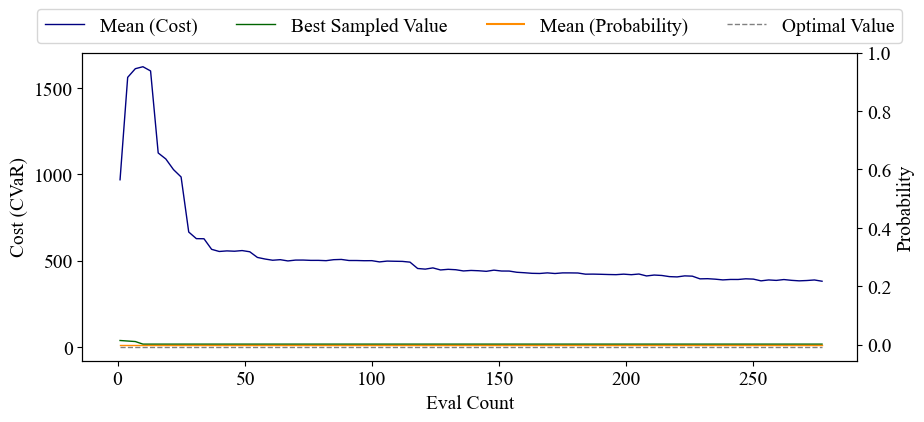

In [12]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.default'] = 'it'

fig, ax = plt.subplots(figsize=(10, 4))
ax2 = ax.twinx()

ax.plot(L1, L2, color='navy', linewidth=1, label='Mean (Cost)')
ax.plot(L1, L4, color='darkgreen', linewidth=1, label='Best Sampled Value')

ax.set_ylabel('Cost (CVaR)')
ax.set_xlabel('Eval Count')

ax.hlines(refval, xmin=0, xmax=0, color='darkorange', label='Mean (Probability)')
ax.hlines(refval, xmin=1, xmax=L1[-1], color='grey', linestyle='dashed', linewidth=1, label='Optimal Value')
ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)

ax2.plot(L1, L3, color='darkorange', linewidth=1)
ax2.set_ylabel('Probability')
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.show()

In [13]:
x = QuantumSolver.x
print(x)
print(b - A@x)

[1 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1
 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1
 0 1 0 0 1 0]
[-1  0  3  2  0  3 -2  2 -3]
